In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('missing').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/05 13:49:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
wash_df = spark.read.csv("WASH.csv",header=True)
death_df = spark.read.csv("unsafewaterdeathrate.csv",header=True)
gdp_df = spark.read.csv("gdp-per-capita-worldbank.csv",header=True)

In [3]:
from pyspark.sql.types import (StructField,StringType,IntegerType,FloatType,StructType)
data_schema = [StructField('Entity',StringType(),True),
              StructField('Code',StringType(),True),
              StructField('Year',IntegerType(),True),
              StructField('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized',FloatType(),True)]
final_struct = StructType(fields=data_schema)
death_df = spark.read.csv("unsafewaterdeathrate.csv",schema=final_struct,header=True)
death_df.printSchema()

data_schema = [StructField('Entity',StringType(),True),
              StructField('Code',StringType(),True),
              StructField('Year',IntegerType(),True),
              StructField('GDP per capita, PPP (constant 2017 international $)',FloatType(),True)]
final_struct = StructType(fields=data_schema)
gdp_df = spark.read.csv("gdp-per-capita-worldbank.csv",schema=final_struct,header=True)
gdp_df.printSchema()

data_schema = [StructField('Type',StringType(),True),
              StructField('Region',StringType(),True),
              StructField("Residence Type",StringType(),True),
              StructField("Service Type",StringType(),True),
              StructField('Year',IntegerType(),True),
              StructField('Coverage',FloatType(),True),
              StructField('Population',FloatType(),True),
              StructField('Facility type',StringType(),True)]
final_struct = StructType(fields=data_schema)
wash_df = spark.read.csv("WASH.csv",schema=final_struct,header=True)
wash_df.printSchema()

root
 |-- Entity: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized: float (nullable = true)

root
 |-- Entity: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- GDP per capita, PPP (constant 2017 international $): float (nullable = true)

root
 |-- Type: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Residence Type: string (nullable = true)
 |-- Service Type: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Coverage: float (nullable = true)
 |-- Population: float (nullable = true)
 |-- Facility type: string (nullable = true)



## Select Target variables for our analysis


In [4]:
# drop the 'Type' column
wash_df = wash_df.drop('Type')
wash_df.describe().show()

+-------+-------------------+--------------+--------------+-----------------+-----------------+--------------------+--------------------+
|summary|             Region|Residence Type|  Service Type|             Year|         Coverage|          Population|       Facility type|
+-------+-------------------+--------------+--------------+-----------------+-----------------+--------------------+--------------------+
|  count|                600|           600|           600|              600|              600|                 600|                 600|
|   mean|               null|          null|          null|           2016.5|33.61109341591597|4.3656411323833334E8|                null|
| stddev|               null|          null|          null|2.874677887159652|27.21752830198907| 4.782407787147155E8|                null|
|    min|        High income|         rural|Drinking water|             2012|          0.78282|           7231180.5|Improved latrine ...|
|    max|Upper middle income|     

In [5]:
# drop the 'Code' column
death_df = death_df.drop('Code')
death_df.describe().show()

+-------+-----------+-----------------+---------------------------------------------------------------------------------------------------------------------+
|summary|     Entity|             Year|Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized|
+-------+-----------+-----------------+---------------------------------------------------------------------------------------------------------------------+
|  count|       6840|             6840|                                                                                                                 6840|
|   mean|       null|           2004.5|                                                                                                   2.2082172846679153|
| stddev|       null|8.656074225491706|                                                                                                     3.09963769859107|
|    min|Afghanistan|             1990|             

### Coerce outliers and extremes

In [6]:
# coerce outliers and extremes
from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType, FloatType, DoubleType

numeric_cols = [f.name for f in wash_df.schema.fields if isinstance(f.dataType, (DoubleType, IntegerType, FloatType))]

# Identify numeric columns
numeric_cols = [f.name for f in wash_df.schema.fields if isinstance(f.dataType, (DoubleType, IntegerType, FloatType))]

for column in numeric_cols:
    Q1, Q3 = wash_df.approxQuantile(column, [0.25, 0.75], 0.05)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Coerce outliers using withColumn and when
    wash_df = wash_df.withColumn(column, 
                                 when(col(column) > upper_bound, upper_bound)
                                 .when(col(column) < lower_bound, lower_bound)
                                 .otherwise(col(column)))

In [7]:
Q1, Q3 = death_df.approxQuantile('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized', [0.25, 0.75], 0.05)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with closest point
death_df = death_df.withColumn ('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized', 
                               when(col('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized') < lower_bound, lower_bound)
                               .when(col('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized') > upper_bound, upper_bound)
                               .otherwise(col('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized')))


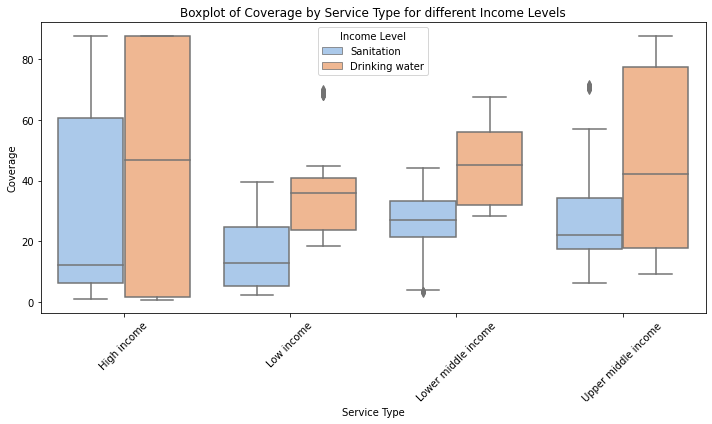

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pdf = wash_df.select('Service Type', 'Coverage', 'Region').toPandas()

# Use Seaborn for the Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='Coverage', hue='Service Type', data=pdf, palette='pastel')
plt.xlabel('Service Type')
plt.ylabel('Coverage')
plt.title('Boxplot of Coverage by Service Type for different Income Levels')
plt.xticks(rotation=45)
plt.legend(title='Income Level')
plt.tight_layout()
plt.show()


In [9]:
# filter irrelevant years
wash_df = wash_df.filter((col('Year') >= 2012) & (col('Year') <= 2019))
wash_df.describe().show()

death_df = death_df.filter((col('Year') >= 2012) & (col('Year') <= 2019))
death_df = death_df.withColumnRenamed('Share of total deaths that are from all causes attributed to unsafe water source, in both sexes aged age-standardized', 'MortalityRate')
death_df.describe().show()

gdp_df = gdp_df.filter((col('Year') >= 2012) & (col('Year') <= 2019))
gdp_df.describe().show()

+-------+-------------------+--------------+--------------+------------------+------------------+-------------------+--------------------+
|summary|             Region|Residence Type|  Service Type|              Year|          Coverage|         Population|       Facility type|
+-------+-------------------+--------------+--------------+------------------+------------------+-------------------+--------------------+
|  count|                480|           480|           480|               480|               480|                480|                 480|
|   mean|               null|          null|          null|            2015.5| 32.80813794583082| 4.07657743153125E8|                null|
| stddev|               null|          null|          null|2.2936783414483375|25.975740073631226|4.151475955874268E8|                null|
|    min|        High income|         rural|Drinking water|            2012.0|0.8136500120162964|          7691625.0|Improved latrine ...|
|    max|Upper middle incom

### data construction

In [10]:
# compute the mean gdp by country
from pyspark.sql.functions import avg
mean_gdp_by_country = gdp_df.groupBy('Entity').agg(avg('GDP per capita, PPP (constant 2017 international $)')\
                                                   .alias('Mean GDP'))
mean_gdp_by_country.show()

+--------------------+------------------+
|              Entity|          Mean GDP|
+--------------------+------------------+
|                Chad|1709.7349700927734|
|            Paraguay|12897.003295898438|
|              Russia|   26142.384765625|
|               Macao|  132393.048828125|
|               World|15644.167602539062|
|             Senegal|   3092.4306640625|
|              Sweden| 50679.15185546875|
|            Kiribati|1965.1893157958984|
|              Guyana| 11790.31591796875|
|         Philippines| 7472.155212402344|
|            Djibouti| 4241.804757254465|
|               Tonga| 5865.833190917969|
|            Malaysia|24603.265380859375|
|           Singapore|    91007.55078125|
|                Fiji|12008.389526367188|
|              Turkey|25802.285400390625|
|              Malawi|1442.6949920654297|
|                Iraq| 9749.670043945312|
|Sint Maarten (Dut...| 41090.00725446428|
|             Germany| 51761.03564453125|
+--------------------+------------

In [11]:
# convert into incomelevels
income_category = mean_gdp_by_country.withColumn("IncomeLevel",
    when(col("`Mean GDP`") <= 1897.289, "Low income")
    .when((col("`Mean GDP`") > 1897.289) & (col("`Mean GDP`") <= 6464.184), "Lower middle income")
    .when((col("`Mean GDP`") > 6464.184) & (col("`Mean GDP`") <= 15324.779), "Upper middle income")
    .otherwise("High income")
)
income_category.show()

+--------------------+------------------+-------------------+
|              Entity|          Mean GDP|        IncomeLevel|
+--------------------+------------------+-------------------+
|                Chad|1709.7349700927734|         Low income|
|            Paraguay|12897.003295898438|Upper middle income|
|              Russia|   26142.384765625|        High income|
|               Macao|  132393.048828125|        High income|
|               World|15644.167602539062|        High income|
|             Senegal|   3092.4306640625|Lower middle income|
|              Sweden| 50679.15185546875|        High income|
|            Kiribati|1965.1893157958984|Lower middle income|
|              Guyana| 11790.31591796875|Upper middle income|
|         Philippines| 7472.155212402344|Upper middle income|
|            Djibouti| 4241.804757254465|Lower middle income|
|               Tonga| 5865.833190917969|Lower middle income|
|            Malaysia|24603.265380859375|        High income|
|       

In [12]:
death_gdp_df = death_df.join(income_category, death_df["Entity"] \
                             == income_category["Entity"], how='inner').drop(income_category["Entity"])
death_gdp_df.show()

+--------+----+--------------------+------------------+-------------------+
|  Entity|Year|       MortalityRate|          Mean GDP|        IncomeLevel|
+--------+----+--------------------+------------------+-------------------+
|    Chad|2019|   7.417001601308584|1709.7349700927734|         Low income|
|    Chad|2018|   7.417001601308584|1709.7349700927734|         Low income|
|    Chad|2017|   7.417001601308584|1709.7349700927734|         Low income|
|    Chad|2016|   7.417001601308584|1709.7349700927734|         Low income|
|    Chad|2015|   7.417001601308584|1709.7349700927734|         Low income|
|    Chad|2014|   7.417001601308584|1709.7349700927734|         Low income|
|    Chad|2013|   7.417001601308584|1709.7349700927734|         Low income|
|    Chad|2012|   7.417001601308584|1709.7349700927734|         Low income|
|Paraguay|2019| 0.32192322611808777|12897.003295898438|Upper middle income|
|Paraguay|2018| 0.32447853684425354|12897.003295898438|Upper middle income|
|Paraguay|20

In [13]:
# Renmae region to "IncomeLeve"
wash_df = wash_df.withColumnRenamed("Region", "IncomeLevel")

In [14]:
# Joining wash_df with death_gdp_df based on 'Year' and 'IncomeLevel' columns
final_df = wash_df.join(death_gdp_df, on=['Year', 'IncomeLevel'], how='inner')
final_df.show()

+------+-----------+--------------+--------------+------------------+------------+--------------------+------+-----------------+------------------+
|  Year|IncomeLevel|Residence Type|  Service Type|          Coverage|  Population|       Facility type|Entity|    MortalityRate|          Mean GDP|
+------+-----------+--------------+--------------+------------------+------------+--------------------+------+-----------------+------------------+
|2019.0| Low income|         urban|Drinking water| 69.44994354248047| 1.4929016E8|      Piped improved|  Chad|7.417001601308584|1709.7349700927734|
|2019.0| Low income|         rural|Drinking water| 22.62067985534668| 9.8127304E7|      Piped improved|  Chad|7.417001601308584|1709.7349700927734|
|2019.0| Low income|         total|Drinking water| 38.11351013183594|2.47263456E8|      Piped improved|  Chad|7.417001601308584|1709.7349700927734|
|2019.0| Low income|         urban|Drinking water| 24.03169059753418| 5.1658724E7|  Non-piped improved|  Chad|7.

In [15]:
from pyspark.sql.types import IntegerType, DoubleType

final_df = (final_df.withColumn("Year", final_df["Year"].cast(IntegerType()))
                   .withColumn("Coverage", final_df["Coverage"].cast(DoubleType()))
                   .withColumn("MortalityRate", final_df["MortalityRate"].cast(DoubleType()))
                   .withColumn("Population", final_df["Population"].cast(DoubleType()))
                   .withColumn("Mean GDP", final_df["Mean GDP"].cast(DoubleType())))


In [16]:
final_df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- IncomeLevel: string (nullable = true)
 |-- Residence Type: string (nullable = true)
 |-- Service Type: string (nullable = true)
 |-- Coverage: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Facility type: string (nullable = true)
 |-- Entity: string (nullable = true)
 |-- MortalityRate: double (nullable = true)
 |-- Mean GDP: double (nullable = true)



In [19]:
from pyspark.sql.functions import col, when

final_df = final_df.withColumn("IncomeLevel", 
                               when(col("IncomeLevel") == "Lower middle income", 1)
                               .when(col("IncomeLevel") == "Upper middle income", 2)
                               .when(col("IncomeLevel") == "High income", 3)
                               .when(col("IncomeLevel") == "Low income", 0)
                               .otherwise(col("IncomeLevel")))

final_df = final_df.withColumn("Service Type", 
                               when(col("Service Type") == "Sanitation", 1)
                               .when(col("Service Type") == "Drinking water", 2)
                               .otherwise(col("Service Type")))

final_df = final_df.withColumn("Residence Type", 
                               when(col("Residence Type") == "total", 1)
                               .when(col("Residence Type") == "rural", 2)
                               .when(col("Residence Type") == "urban", 3)
                               .otherwise(col("Residence Type")))

final_df = final_df.withColumn("Facility type", 
                               when(col("Facility type") == "Improved latrine and other", 1)
                               .when(col("Facility type") == "Septic tank", 2)
                               .when(col("Facility type") == "Sewer", 3)
                               .when(col("Facility type") == "Non-piped improved", 4)
                               .when(col("Facility type") == "Piped improved", 5)
                               .otherwise(col("Facility type")))

final_df.show()

+----+-----------+--------------+------------+------------------+------------+-------------+------+-----------------+------------------+
|Year|IncomeLevel|Residence Type|Service Type|          Coverage|  Population|Facility type|Entity|    MortalityRate|          Mean GDP|
+----+-----------+--------------+------------+------------------+------------+-------------+------+-----------------+------------------+
|2019|          0|             3|           2| 69.44994354248047| 1.4929016E8|            5|  Chad|7.417001601308584|1709.7349700927734|
|2019|          0|             2|           2| 22.62067985534668| 9.8127304E7|            5|  Chad|7.417001601308584|1709.7349700927734|
|2019|          0|             1|           2| 38.11351013183594|2.47263456E8|            5|  Chad|7.417001601308584|1709.7349700927734|
|2019|          0|             3|           2| 24.03169059753418| 5.1658724E7|            4|  Chad|7.417001601308584|1709.7349700927734|
|2019|          0|             2|        

In [18]:
final_df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- IncomeLevel: string (nullable = true)
 |-- Residence Type: string (nullable = true)
 |-- Service Type: string (nullable = true)
 |-- Coverage: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- Facility type: string (nullable = true)
 |-- Entity: string (nullable = true)
 |-- MortalityRate: double (nullable = true)
 |-- Mean GDP: double (nullable = true)

